ASPECT-BASED SENTIMENT ANALYSIS - THREE APPROACHES

Text: The pizza was delicious but the service was terrible.

Lexicon Results:
  Aspect: 'The pizza' → Sentiment: POSITIVE (confidence: 0.57)
  Aspect: 'the service' → Sentiment: NEGATIVE (confidence: 0.48)
  Time: 0.009s

Transformer Results:
  Aspect: 'The pizza' → Sentiment: POSITIVE (confidence: 1.00)
  Aspect: 'the service' → Sentiment: NEGATIVE (confidence: 0.99)
  Time: 0.243s

LLM Results:
  Aspect: 'pizza' → Sentiment: POSITIVE (confidence: 0.85)
  Aspect: 'service' → Sentiment: NEGATIVE (confidence: 0.90)
  Time: 20.974s

Text: Great battery life but the camera quality is disappointing.

Lexicon Results:
  Aspect: 'Great battery life' → Sentiment: POSITIVE (confidence: 0.23)
  Aspect: 'the camera quality' → Sentiment: NEGATIVE (confidence: 0.65)
  Time: 0.008s

Transformer Results:
  Aspect: 'Great battery life' → Sentiment: POSITIVE (confidence: 1.00)
  Aspect: 'the camera quality' → Sentiment: NEGATIVE (confidence: 1.00)
  

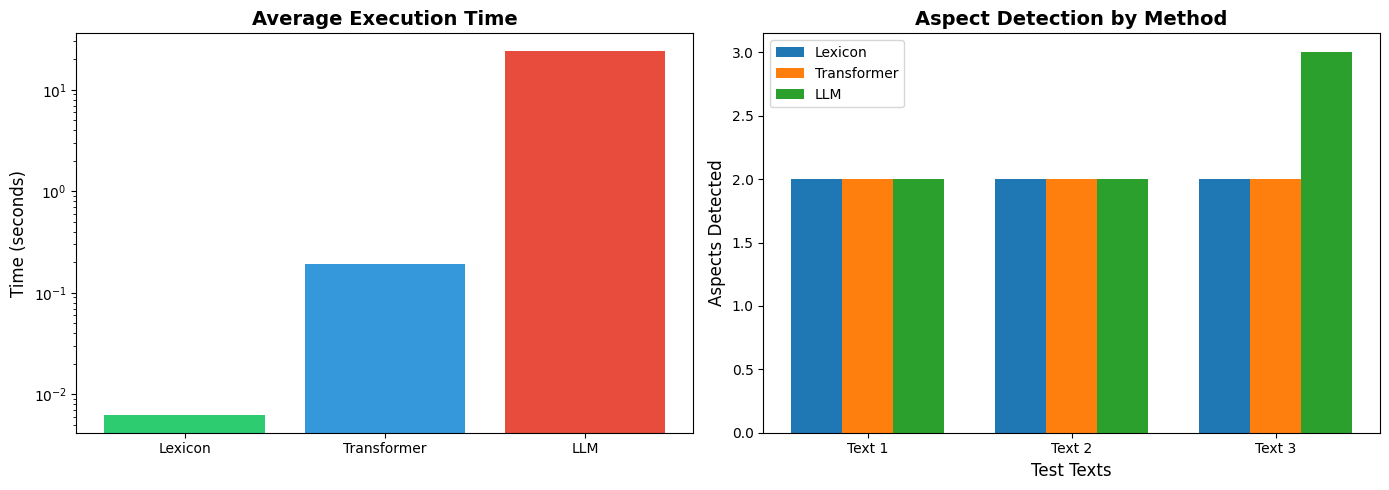


🔍 DETAILED COMPARISON - TEXT 1

Text: 'The pizza was delicious but the service was terrible.'

     Method      Aspect Sentiment Confidence
    Lexicon   The pizza  positive       0.57
    Lexicon the service  negative       0.48
Transformer   The pizza  positive       1.00
Transformer the service  negative       0.99
        LLM       pizza  positive       0.95
        LLM     service  negative       0.85

⚠️ EDGE CASES

Negation: 'wasn't bad'
  Lexicon: 0 aspects
  Transformer: 0 aspects
  LLM: 1 aspects
Neutral: 'okay'
  Lexicon: 0 aspects
  Transformer: 0 aspects
  LLM: 1 aspects

 RECOMMENDATIONS:
Real-time API → Lexicon | Production → Transformer | Research → LLM


In [2]:
from src.lexicon_absa import LexiconABSA
from src.transformer_absa import TransformerABSA
from src.llm_absa import LLMABSA
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

print("="*60)
print("ASPECT-BASED SENTIMENT ANALYSIS - THREE APPROACHES")
print("="*60)

# Load test samples from JSON
with open('../data/test_samples.json', 'r') as f:
    test_data = json.load(f)

test_texts = [item['text'] for item in test_data]

# Initialize all analyzers
analyzers = {
    'Lexicon': LexiconABSA(),
    'Transformer': TransformerABSA(),
    'LLM': LLMABSA()
}

# Compare results
for idx, item in enumerate(test_data):
    text = item['text']
    expected = item['expected']

    print(f"\n{'='*60}")
    print(f"Text {idx+1}: {text}")
    print(f"Expected: {expected}")
    print('='*60)

    for name, analyzer in analyzers.items():
        print(f"\n{name} Results:")
        start = time.time()
        results = analyzer.analyze(text)
        elapsed = time.time() - start

        for r in results:
            print(f"  {r}")
        print(f"  Time: {elapsed:.3f}s")

# Summary table
summary_data = []
for item in test_data:
    text = item['text']
    row = {'text': text[:50] + '...', 'expected_aspects': len(item['expected'])}

    for name, analyzer in analyzers.items():
        start = time.time()
        results = analyzer.analyze(text)
        row[f'{name}_aspects'] = len(results)
        row[f'{name}_time'] = f"{time.time() - start:.3f}s"
    summary_data.append(row)

print("\n📋 SUMMARY TABLE\n")
print(pd.DataFrame(summary_data).to_string(index=False))

# === ACCURACY EVALUATION ===
print("\n ACCURACY EVALUATION\n")

accuracy_data = []
for item in test_data:
    text = item['text']
    expected = item['expected']
    expected_aspects = {e['aspect'].lower() for e in expected}
    expected_sentiments = {e['aspect'].lower(): e['sentiment'] for e in expected}

    for name, analyzer in analyzers.items():
        results = analyzer.analyze(text)
        detected_aspects = {r.aspect.lower() for r in results}

        # Calculate metrics
        correct_aspects = len(expected_aspects & detected_aspects)
        precision = correct_aspects / len(detected_aspects) if detected_aspects else 0
        recall = correct_aspects / len(expected_aspects) if expected_aspects else 0

        # Check sentiment accuracy
        sentiment_correct = 0
        for r in results:
            aspect_lower = r.aspect.lower()
            if aspect_lower in expected_sentiments:
                if r.sentiment == expected_sentiments[aspect_lower]:
                    sentiment_correct += 1

        sentiment_accuracy = sentiment_correct / len(expected) if expected else 0

        accuracy_data.append({
            'Method': name,
            'Text': text[:30] + '...',
            'Precision': f"{precision:.2f}",
            'Recall': f"{recall:.2f}",
            'Sentiment_Acc': f"{sentiment_accuracy:.2f}"
        })

df_accuracy = pd.DataFrame(accuracy_data)
print(df_accuracy.to_string(index=False))

# === PERFORMANCE METRICS ===
print("\n📊 PERFORMANCE COMPARISON\n")

# Extract timing data
timing_data = {name: [] for name in analyzers.keys()}
for item in test_data:
    text = item['text']
    for name, analyzer in analyzers.items():
        start = time.time()
        _ = analyzer.analyze(text)
        timing_data[name].append(time.time() - start)

# Plot: Timing + Accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Average time
avg_times = {name: np.mean(times) for name, times in timing_data.items()}
axes[0].bar(avg_times.keys(), avg_times.values(), color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0].set_ylabel('Time (seconds)', fontsize=12)
axes[0].set_title('Average Execution Time', fontsize=14, fontweight='bold')
axes[0].set_yscale('log')

# Plot 2: Aspects detected
aspect_counts = {name: [] for name in analyzers.keys()}
for item in test_data:
    text = item['text']
    for name, analyzer in analyzers.items():
        results = analyzer.analyze(text)
        aspect_counts[name].append(len(results))

x = np.arange(len(test_data))
width = 0.25
for i, (name, counts) in enumerate(aspect_counts.items()):
    axes[1].bar(x + i*width, counts, width, label=name)
axes[1].set_xlabel('Test Texts', fontsize=12)
axes[1].set_ylabel('Aspects Detected', fontsize=12)
axes[1].set_title('Aspect Detection by Method', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels([f'Text {i+1}' for i in range(len(test_data))])
axes[1].legend()

# Plot 3: Sentiment accuracy by method
sentiment_acc_by_method = {}
for row in accuracy_data:
    method = row['Method']
    acc = float(row['Sentiment_Acc'])
    if method not in sentiment_acc_by_method:
        sentiment_acc_by_method[method] = []
    sentiment_acc_by_method[method].append(acc)

avg_sentiment_acc = {name: np.mean(accs) for name, accs in sentiment_acc_by_method.items()}
axes[2].bar(avg_sentiment_acc.keys(), avg_sentiment_acc.values(), color=['#2ecc71', '#3498db', '#e74c3c'])
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_title('Sentiment Classification Accuracy', fontsize=14, fontweight='bold')
axes[2].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# === QUALITATIVE ANALYSIS ===
print("\n🔍 DETAILED COMPARISON - TEXT 1\n")
text = test_data[0]['text']
expected = test_data[0]['expected']
print(f"Text: '{text}'")
print(f"Expected: {expected}\n")

comparison_results = []
for name, analyzer in analyzers.items():
    results = analyzer.analyze(text)
    for r in results:
        comparison_results.append({
            'Method': name,
            'Aspect': r.aspect,
            'Sentiment': r.sentiment,
            'Confidence': f"{r.confidence:.2f}"
        })

df_comparison = pd.DataFrame(comparison_results)
print(df_comparison.to_string(index=False))

# === EDGE CASES ===
print("\n EDGE CASES\n")
for text, label in [("wasn't bad", "Negation"), ("okay", "Neutral")]:
    print(f"{label}: '{text}'")
    for name, analyzer in analyzers.items():
        r = analyzer.analyze(text)
        print(f"  {name}: {len(r)} aspects - {[res.sentiment for res in r]}")

# === RECOMMENDATIONS ===
print("\n RECOMMENDATIONS:")
print("Real-time API → Lexicon | Production → Transformer | Research → LLM")